In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm
import numpy as np
import os
from albumentations import (
    Compose, RandomResizedCrop, HorizontalFlip, Rotate, ColorJitter,
    GaussNoise, ElasticTransform, GridDistortion, CoarseDropout,
    Normalize, Resize
)
from albumentations.pytorch import ToTensorV2
import urllib.request
import hashlib
import os


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device, torch.cuda.get_device_name(0))

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Device: cuda NVIDIA A100-SXM4-40GB


In [3]:
data_flag = 'pathmnist'
download = True
batch_size = 256

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Ensure MedMNIST root exists and dataset file is present
medmnist_root = os.path.expanduser('~/.medmnist')
os.makedirs(medmnist_root, exist_ok=True)

# Download the required npz if missing (will be placed under ~/.medmnist)
url = info.get('url')
expected_md5 = info.get('MD5')

if url is not None:
    fname = os.path.join(medmnist_root, os.path.basename(url.split('?')[0]))
    if not os.path.exists(fname):
        print(f"Downloading {os.path.basename(fname)} to {medmnist_root}")
        urllib.request.urlretrieve(url, fname)
        # Verify md5 if available
    if expected_md5:
        with open(fname, 'rb') as f:
            md5 = hashlib.md5(f.read()).hexdigest()
        if md5 != expected_md5:
            raise RuntimeError(
                f"MD5 mismatch for {fname}: expected {expected_md5}, got {md5}")

# Data augmentation transforms


def _albu_adapter(albu_compose):
    def _apply(img):
        if isinstance(img, np.ndarray):
            image = img
        else:
            image = np.array(img)
        result = albu_compose(image=image)
        return result['image']
    return _apply


train_transform = _albu_adapter(Compose([
    RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0)),
    HorizontalFlip(p=0.5),
    Rotate(limit=20),
    ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
]))

val_transform = _albu_adapter(Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
]))

# Load the data (we already ensured the npz file is present, so disable automatic download)
train_dataset = DataClass(
    split='train', transform=train_transform, download=False)
val_dataset = DataClass(
    split='val', transform=val_transform, download=False)
test_dataset = DataClass(
    split='test', transform=val_transform, download=False)

pil_dataset = DataClass(split='train', download=False)

# Encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(
    dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/syc/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-

In [4]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Progressive unfreezing function


def set_trainable_layers(model, stage):
    # First train only fc, then unfreeze fc + layer4, finally fc + layer4 + layer3
    for name, param in model.named_parameters():
        if stage == 1:
            param.requires_grad = ('fc' in name)
        elif stage == 2:
            param.requires_grad = any(
                layer in name for layer in ['layer4', 'fc'])
        elif stage == 3:
            param.requires_grad = any(layer in name for layer in [
                'layer3', 'layer4', 'fc'])
    print(f"Proportion of trainable parameters in the current stage {stage}: "
          f"{sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()):.2%}")


def make_optimizer(model, stage):
    params = []
    if stage >= 1:
        params.append({'params': model.fc.parameters(), 'lr': 1e-3})
    if stage >= 2:
        params.append({'params': model.layer4.parameters(), 'lr': 1e-4})
    if stage >= 3:
        params.append({'params': model.layer3.parameters(), 'lr': 5e-5})
    return torch.optim.AdamW(params, weight_decay=0.05)



/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
epochs_stage = [10, 20, 20]  # Epochs per stage
best_acc = 0.0
save_path = "pathmnist_resnet50_progressive_best.pth"

print('Begin Training:')

# Progressive training loop
for stage, stage_epochs in enumerate(epochs_stage, start=1):
    print(f"Stage {stage} Training")
    set_trainable_layers(model, stage)
    optimizer = make_optimizer(model, stage)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=stage_epochs)

    for epoch in range(stage_epochs):
        model.train()
        train_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Stage {stage} Epoch {epoch+1}/{stage_epochs} [Train]"):
            x, y = x.to(device), y.to(device).long()
            # In case of using albumentations, the labels are not one-hot encoded
            if len(y.shape) > 1 and y.shape[1] > 1:
                y = y.argmax(dim=1)
            logits = model(x)
            loss = criterion(logits, y.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        # Validation on val set
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                if len(y.shape) > 1 and y.shape[1] > 1:
                    y = y.argmax(dim=1)
                pred = model(x).argmax(dim=1)
                correct += pred.eq(y.squeeze()).sum().item()
                total += y.size(0)
        acc = 100. * correct / total
        print(
            f"Stage {stage} Epoch {epoch+1} |  Loss: {train_loss/len(train_loader):.4f} , Acc: {acc:.4f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved  {save_path}")

print(f"Training completed. Best Acc: {best_acc:.3f}%")

# Test final performance on test set
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.load_state_dict(torch.load(save_path))
model.to(device)

model.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)
        pred = model(x).argmax(dim=1)
        correct += pred.eq(y.squeeze()).sum().item()
        total += y.size(0)
test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.4f}%")



Begin Training:
Stage 1 Training
Proportion of trainable parameters in the current stage 1: 0.08%


Stage 1 Epoch 1/10 [Train]: 100%|██████████| 352/352 [02:38<00:00,  2.22it/s]


Stage 1 Epoch 1 |  Loss: 0.8055 , Acc: 85.7057%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 2/10 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 1 Epoch 2 |  Loss: 0.5943 , Acc: 87.6549%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 3/10 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Stage 1 Epoch 3 |  Loss: 0.5531 , Acc: 87.8749%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 4/10 [Train]: 100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Stage 1 Epoch 4 |  Loss: 0.5296 , Acc: 88.7045%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 5/10 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Stage 1 Epoch 5 |  Loss: 0.5182 , Acc: 89.2943%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 6/10 [Train]: 100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Stage 1 Epoch 6 |  Loss: 0.5103 , Acc: 88.5246%


Stage 1 Epoch 7/10 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.29it/s]


Stage 1 Epoch 7 |  Loss: 0.5020 , Acc: 89.2243%


Stage 1 Epoch 8/10 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Stage 1 Epoch 8 |  Loss: 0.4958 , Acc: 89.2343%


Stage 1 Epoch 9/10 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Stage 1 Epoch 9 |  Loss: 0.4908 , Acc: 89.4442%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 1 Epoch 10/10 [Train]: 100%|██████████| 352/352 [02:37<00:00,  2.24it/s]


Stage 1 Epoch 10 |  Loss: 0.4858 , Acc: 89.3643%
Stage 2 Training
Proportion of trainable parameters in the current stage 2: 63.69%


Stage 2 Epoch 1/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 2 Epoch 1 |  Loss: 0.3216 , Acc: 94.7521%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 2/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.21it/s]


Stage 2 Epoch 2 |  Loss: 0.2095 , Acc: 96.3315%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 3/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 3 |  Loss: 0.1697 , Acc: 97.0312%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 4/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.21it/s]


Stage 2 Epoch 4 |  Loss: 0.1474 , Acc: 97.1811%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 5/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 5 |  Loss: 0.1334 , Acc: 97.8509%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 6/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 6 |  Loss: 0.1198 , Acc: 98.0208%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 7/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 7 |  Loss: 0.1099 , Acc: 97.4610%


Stage 2 Epoch 8/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.21it/s]


Stage 2 Epoch 8 |  Loss: 0.1012 , Acc: 98.3906%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 9/20 [Train]: 100%|██████████| 352/352 [02:38<00:00,  2.21it/s]


Stage 2 Epoch 9 |  Loss: 0.0925 , Acc: 98.0508%


Stage 2 Epoch 10/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.21it/s]


Stage 2 Epoch 10 |  Loss: 0.0852 , Acc: 98.2807%


Stage 2 Epoch 11/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.21it/s]


Stage 2 Epoch 11 |  Loss: 0.0790 , Acc: 98.3207%


Stage 2 Epoch 12/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 12 |  Loss: 0.0734 , Acc: 98.4806%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 13/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.19it/s]


Stage 2 Epoch 13 |  Loss: 0.0675 , Acc: 98.6805%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 14/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.19it/s]


Stage 2 Epoch 14 |  Loss: 0.0632 , Acc: 98.5806%


Stage 2 Epoch 15/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 2 Epoch 15 |  Loss: 0.0582 , Acc: 98.7505%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 16/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.19it/s]


Stage 2 Epoch 16 |  Loss: 0.0529 , Acc: 98.6805%


Stage 2 Epoch 17/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 2 Epoch 17 |  Loss: 0.0512 , Acc: 98.7705%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 18/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 2 Epoch 18 |  Loss: 0.0475 , Acc: 98.9104%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 2 Epoch 19/20 [Train]: 100%|██████████| 352/352 [02:39<00:00,  2.20it/s]


Stage 2 Epoch 19 |  Loss: 0.0476 , Acc: 98.9004%


Stage 2 Epoch 20/20 [Train]: 100%|██████████| 352/352 [02:40<00:00,  2.20it/s]


Stage 2 Epoch 20 |  Loss: 0.0464 , Acc: 98.9204%
New best model saved  pathmnist_resnet50_progressive_best.pth
Stage 3 Training
Proportion of trainable parameters in the current stage 3: 93.86%


Stage 3 Epoch 1/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.01it/s]


Stage 3 Epoch 1 |  Loss: 0.0906 , Acc: 98.4306%


Stage 3 Epoch 2/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 2 |  Loss: 0.0791 , Acc: 98.3507%


Stage 3 Epoch 3/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 3 |  Loss: 0.0714 , Acc: 98.5406%


Stage 3 Epoch 4/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 4 |  Loss: 0.0634 , Acc: 98.5306%


Stage 3 Epoch 5/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 5 |  Loss: 0.0557 , Acc: 98.5406%


Stage 3 Epoch 6/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 6 |  Loss: 0.0504 , Acc: 98.6305%


Stage 3 Epoch 7/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.01it/s]


Stage 3 Epoch 7 |  Loss: 0.0481 , Acc: 98.5706%


Stage 3 Epoch 8/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.01it/s]


Stage 3 Epoch 8 |  Loss: 0.0402 , Acc: 98.9704%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 3 Epoch 9/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 9 |  Loss: 0.0380 , Acc: 99.0804%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 3 Epoch 10/20 [Train]: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Stage 3 Epoch 10 |  Loss: 0.0345 , Acc: 99.0404%


Stage 3 Epoch 11/20 [Train]: 100%|██████████| 352/352 [02:58<00:00,  1.98it/s]


Stage 3 Epoch 11 |  Loss: 0.0296 , Acc: 98.9704%


Stage 3 Epoch 12/20 [Train]: 100%|██████████| 352/352 [02:55<00:00,  2.01it/s]


Stage 3 Epoch 12 |  Loss: 0.0264 , Acc: 99.0004%


Stage 3 Epoch 13/20 [Train]: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Stage 3 Epoch 13 |  Loss: 0.0228 , Acc: 99.1803%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 3 Epoch 14/20 [Train]: 100%|██████████| 352/352 [02:55<00:00,  2.01it/s]


Stage 3 Epoch 14 |  Loss: 0.0216 , Acc: 99.1603%


Stage 3 Epoch 15/20 [Train]: 100%|██████████| 352/352 [02:55<00:00,  2.00it/s]


Stage 3 Epoch 15 |  Loss: 0.0178 , Acc: 99.1204%


Stage 3 Epoch 16/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Stage 3 Epoch 16 |  Loss: 0.0158 , Acc: 99.2503%
New best model saved  pathmnist_resnet50_progressive_best.pth


Stage 3 Epoch 17/20 [Train]: 100%|██████████| 352/352 [02:54<00:00,  2.01it/s]


Stage 3 Epoch 17 |  Loss: 0.0155 , Acc: 99.2503%


Stage 3 Epoch 18/20 [Train]: 100%|██████████| 352/352 [02:55<00:00,  2.01it/s]


Stage 3 Epoch 18 |  Loss: 0.0135 , Acc: 99.2403%


Stage 3 Epoch 19/20 [Train]: 100%|██████████| 352/352 [02:59<00:00,  1.96it/s]


Stage 3 Epoch 19 |  Loss: 0.0121 , Acc: 99.2303%


Stage 3 Epoch 20/20 [Train]: 100%|██████████| 352/352 [02:59<00:00,  1.96it/s]


Stage 3 Epoch 20 |  Loss: 0.0119 , Acc: 99.2103%
Training completed. Best Acc: 99.250%


/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy: 93.1616%


In [6]:
# Frozen pretrained layers section
model = models.resnet50(pretrained=True)

# Freeze all pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace classification head
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.to(device)
print("All pretrained layers frozen")

# Training parameters
trainable_params = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params} / {total_params} ({100.*trainable_params/total_params:.2f}%)")

# Optimizer & loss (optimize only the head)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training parameters
epochs = 30  # Fewer epochs since only training the head
best_acc = 0.0
save_path = "pathmnist_resnet50_frozen_best.pth"

print("Begin training classification head")

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        x, y = x.to(device), y.to(device).long()
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)

        # Forward pass
        logits = model(x)
        loss = criterion(logits, y.squeeze())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation on val set
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            if len(y.shape) > 1 and y.shape[1] > 1:
                y = y.argmax(dim=1)
            pred = model(x).argmax(dim=1)
            correct += pred.eq(y.squeeze()).sum().item()
            total += y.size(0)

    acc = 100. * correct / total
    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Acc: {acc:.4f}% { 'New Best' if acc > best_acc else '' }")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), save_path)
        print(f"The best model saved at: {save_path}")

print(f"Training completed! Best Acc: {best_acc:.4f}%")

# Final test on test set for frozen model
model.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)
        pred = model(x).argmax(dim=1)
        correct += pred.eq(y.squeeze()).sum().item()
        total += y.size(0)
test_acc = 100. * correct / total
print(f"Test Accuracy (Frozen): {test_acc:.4f}%")

All pretrained layers frozen
Trainable parameters: 18441 / 23526473 (0.08%)
Begin training classification head


Epoch 1/30 [Train]: 100%|██████████| 352/352 [02:38<00:00,  2.22it/s]


Epoch 1 | Loss: 0.8267 | Acc: 85.4058% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 2/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 2 | Loss: 0.6200 | Acc: 87.1551% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 3/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 3 | Loss: 0.5945 | Acc: 87.5150% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 4/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 4 | Loss: 0.5843 | Acc: 87.7849% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 5/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 5 | Loss: 0.5802 | Acc: 87.3451% 


Epoch 6/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 6 | Loss: 0.5727 | Acc: 87.7549% 


Epoch 7/30 [Train]: 100%|██████████| 352/352 [02:37<00:00,  2.24it/s]


Epoch 7 | Loss: 0.5755 | Acc: 87.9648% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 8/30 [Train]: 100%|██████████| 352/352 [02:33<00:00,  2.30it/s]


Epoch 8 | Loss: 0.5677 | Acc: 87.9148% 


Epoch 9/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 9 | Loss: 0.5719 | Acc: 88.2147% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 10/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 10 | Loss: 0.5676 | Acc: 87.3151% 


Epoch 11/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 11 | Loss: 0.5691 | Acc: 87.2051% 


Epoch 12/30 [Train]: 100%|██████████| 352/352 [02:36<00:00,  2.26it/s]


Epoch 12 | Loss: 0.5692 | Acc: 87.3551% 


Epoch 13/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.26it/s]


Epoch 13 | Loss: 0.5657 | Acc: 88.0348% 


Epoch 14/30 [Train]: 100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch 14 | Loss: 0.5656 | Acc: 88.0148% 


Epoch 15/30 [Train]: 100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch 15 | Loss: 0.5696 | Acc: 88.7145% New Best
The best model saved at: pathmnist_resnet50_frozen_best.pth


Epoch 16/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 16 | Loss: 0.5721 | Acc: 87.6749% 


Epoch 17/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 17 | Loss: 0.5694 | Acc: 87.7149% 


Epoch 18/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Epoch 18 | Loss: 0.5678 | Acc: 87.9048% 


Epoch 19/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.29it/s]


Epoch 19 | Loss: 0.5690 | Acc: 87.7549% 


Epoch 20/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 20 | Loss: 0.5672 | Acc: 87.9548% 


Epoch 21/30 [Train]: 100%|██████████| 352/352 [02:37<00:00,  2.24it/s]


Epoch 21 | Loss: 0.5688 | Acc: 87.9548% 


Epoch 22/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 22 | Loss: 0.5719 | Acc: 88.1847% 


Epoch 23/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.27it/s]


Epoch 23 | Loss: 0.5690 | Acc: 87.2951% 


Epoch 24/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 24 | Loss: 0.5688 | Acc: 87.4950% 


Epoch 25/30 [Train]: 100%|██████████| 352/352 [02:37<00:00,  2.23it/s]


Epoch 25 | Loss: 0.5681 | Acc: 87.4950% 


Epoch 26/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Epoch 26 | Loss: 0.5680 | Acc: 86.8952% 


Epoch 27/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Epoch 27 | Loss: 0.5655 | Acc: 87.0852% 


Epoch 28/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Epoch 28 | Loss: 0.5676 | Acc: 87.7349% 


Epoch 29/30 [Train]: 100%|██████████| 352/352 [02:35<00:00,  2.27it/s]


Epoch 29 | Loss: 0.5704 | Acc: 88.5246% 


Epoch 30/30 [Train]: 100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch 30 | Loss: 0.5664 | Acc: 88.2347% 
Training completed! Best Acc: 88.7145%
Test Accuracy (Frozen): 87.9805%


Loading model from pathmnist_resnet50_progressive_best.pth


/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating Progressive Model: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


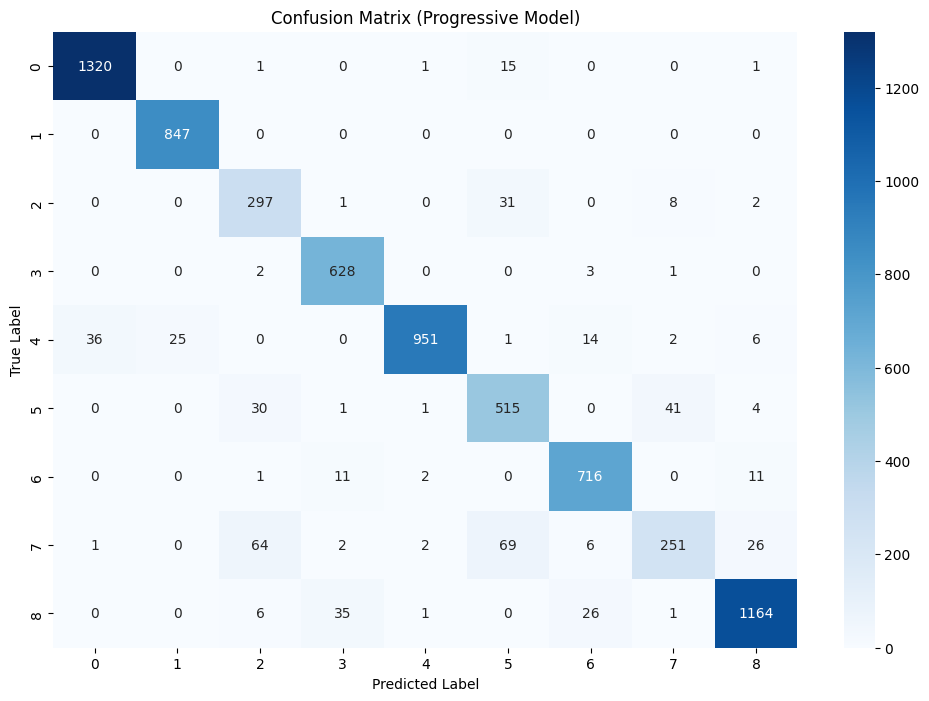

Macro-F1 Score: 0.9018

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9727    0.9865    0.9796      1338
           1     0.9713    1.0000    0.9855       847
           2     0.7406    0.8761    0.8027       339
           3     0.9263    0.9905    0.9573       634
           4     0.9927    0.9188    0.9543      1035
           5     0.8162    0.8699    0.8422       592
           6     0.9359    0.9663    0.9509       741
           7     0.8257    0.5962    0.6924       421
           8     0.9588    0.9440    0.9514      1233

    accuracy                         0.9316      7180
   macro avg     0.9045    0.9054    0.9018      7180
weighted avg     0.9327    0.9316    0.9303      7180



In [5]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Reload the best model from the progressive training stage
progressive_model_path = "pathmnist_resnet50_progressive_best.pth"
print(f"Loading model from {progressive_model_path}")

model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.load_state_dict(torch.load(progressive_model_path))
model.to(device)
model.eval()

all_preds = []
all_targets = []

# Collect predictions and true labels
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating Progressive Model"):
        x, y = x.to(device), y.to(device)
        # Handle potential one-hot encoding or extra dimensions
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)
        
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.squeeze().cpu().numpy())

# 1. Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Progressive Model)')
plt.show()

# 2. Macro-F1 Score
macro_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"Macro-F1 Score: {macro_f1:.4f}")

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))

Loading model from pathmnist_resnet50_frozen_best.pth


/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syc/anaconda3/envs/janus/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating Frozen Model: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


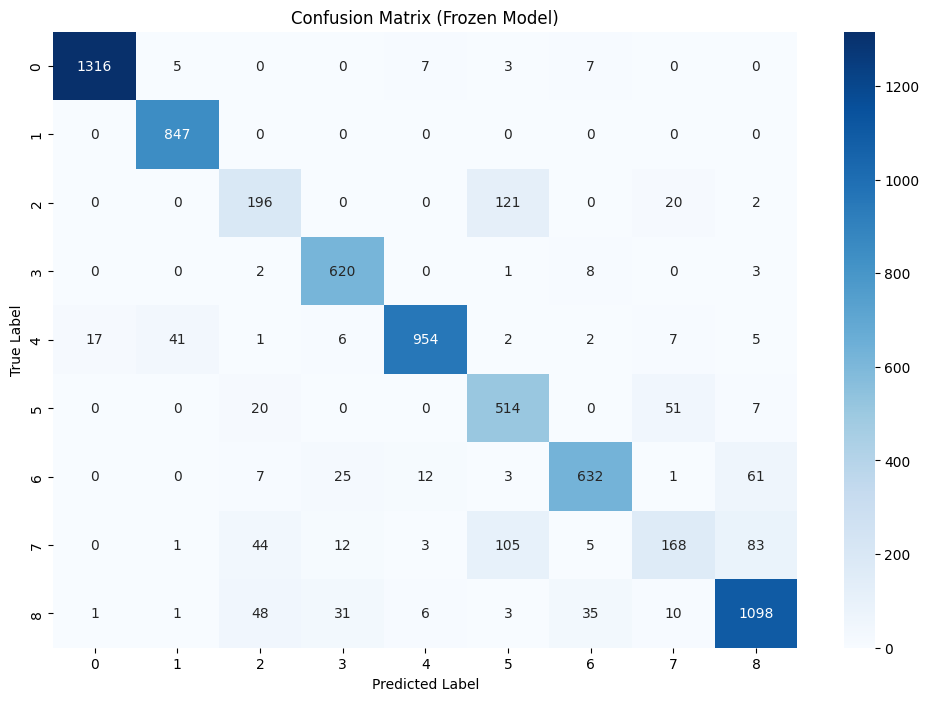

Macro-F1 Score: 0.8288

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9865    0.9836    0.9850      1338
           1     0.9464    1.0000    0.9724       847
           2     0.6164    0.5782    0.5967       339
           3     0.8934    0.9779    0.9337       634
           4     0.9715    0.9217    0.9460      1035
           5     0.6835    0.8682    0.7649       592
           6     0.9173    0.8529    0.8839       741
           7     0.6537    0.3990    0.4956       421
           8     0.8721    0.8905    0.8812      1233

    accuracy                         0.8837      7180
   macro avg     0.8379    0.8302    0.8288      7180
weighted avg     0.8826    0.8837    0.8799      7180



In [6]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Reload the best model from the progressive training stage
model_path = "pathmnist_resnet50_frozen_best.pth"
print(f"Loading model from {model_path}")

model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

all_preds = []
all_targets = []

# Collect predictions and true labels
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating Frozen Model"):
        x, y = x.to(device), y.to(device)
        # Handle potential one-hot encoding or extra dimensions
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)
        
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.squeeze().cpu().numpy())

# 1. Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Frozen Model)')
plt.show()

# 2. Macro-F1 Score
macro_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"Macro-F1 Score: {macro_f1:.4f}")

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))